In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import sys
sys.path.append('/remote/tychodata/ftairli/work/Projects/TraceHexConv/Models')

In [2]:
plt.rcParams['figure.figsize'] = [15, 12]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


D_main_test = torch.load('../Data/NormData/D_main_test.pt')
D_aux_test  = torch.load('../Data/NormData/D_aux_test.pt')
Xmax_test   = torch.load('../Data/NormData/Xmax_test.pt')

# Replace

D_main_test  = torch.load('../Data/NormData/D_main_train.pt').index_select(0,torch.arange(25000))
D_aux_test   = torch.load('../Data/NormData/D_aux_train.pt')[:25000]
Xmax_test    = torch.load('../Data/NormData/Xmax_train.pt')[:25000]


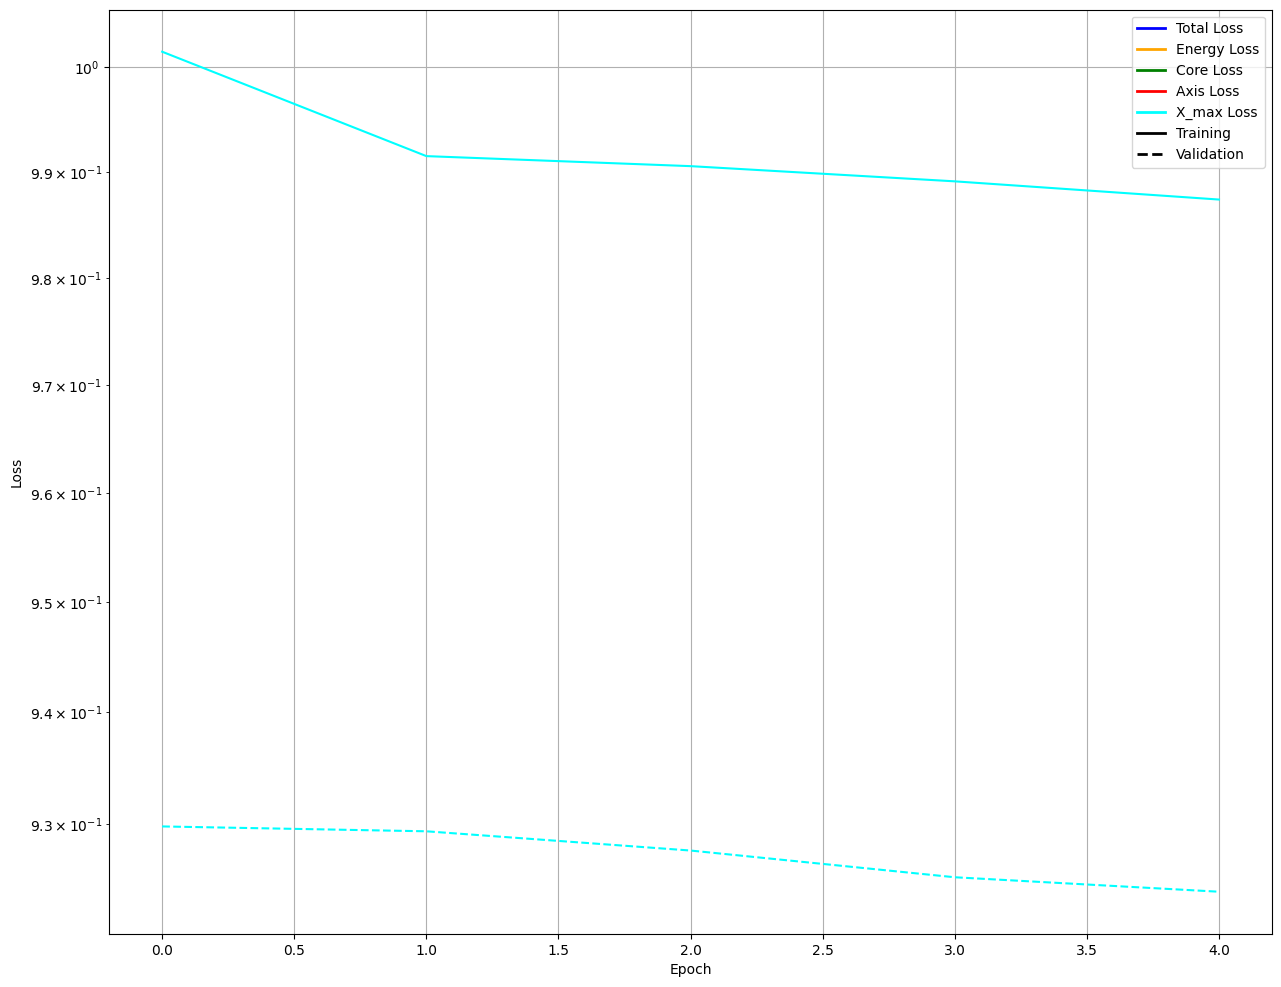

In [4]:
model = torch.load('../Models/Model_X_1.pt')

Epoch_i =0
Epoch_f = 30

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan']


X_loss = np.asarray(model.X_Loss_history)

X_loss_val = np.asarray(model.X_Loss_history_val)

plt.plot(X_loss[Epoch_i:Epoch_f], color=colors[4], label='Xmax Loss - Training')

# Plot validation loss
plt.plot(X_loss_val[Epoch_i:Epoch_f], color=colors[4], linestyle='dashed', label='Xmax Loss - Validation')

# Set up custom legend

custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),
                Line2D([0], [0], color=colors[3], lw=2),
                Line2D([0], [0], color=colors[4], lw=2),
                Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', linestyle='dashed', lw=2)]

plt.legend(custom_lines, ['Total Loss', 'Energy Loss', 'Core Loss', 'Axis Loss','X_max Loss', 'Training', 'Validation'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.show()


In [5]:
print(D_main_test.shape)
print(D_aux_test.shape)

Xmax_pred = np.zeros(shape = (D_main_test.shape[0],1))

model = model.to(device)
model.eval()


batchsize = 100
howmany = int(D_main_test.shape[0]/batchsize)
print(howmany, ' batches of size ', batchsize)
for i in range(howmany):
    indices = np.arange(i*batchsize, (i+1)*batchsize)
    # print(indices)
    print(f'\r {i}', end='')
    with torch.no_grad():
        Results = model(D_main_test.to_dense()[indices].to(device), D_aux_test[indices].to(device).unsqueeze(1))
    Xmax_pred[indices] = Results.cpu().detach().numpy()
    torch.cuda.empty_cache()

del model


torch.Size([25000, 120, 3, 11, 11])
torch.Size([25000, 11, 11])
250  batches of size  100
 249

In [6]:
print(np.mean(Xmax_pred))
print(np.std(Xmax_pred))

0.007895186272636056
0.06068633315738665


In [7]:
# Normalise the values:

Xmax_MEAN     = 750.0
Xmax_STD      = 66.80484050442804 
GlobalTimeSTD = 4094.8664907986326 # dont need to include seconds, as they are always same for simulations
E_MEAN        = 19.0
Norm_LEN      = 750.0
Norm_SIG      = np.log10(10+1) # Normalise for unity at 100 vem + for log10

# Xmax_MEAN = 0
# Xmax_STD  = 1
if type(Xmax_test) != np.ndarray:
    Xmax_pred = Xmax_pred*Xmax_STD + Xmax_MEAN
    # Axis is already normalised

    Xmax_test = Xmax_test*Xmax_STD + Xmax_MEAN
    Xmax_test = Xmax_test.cpu().detach().numpy()

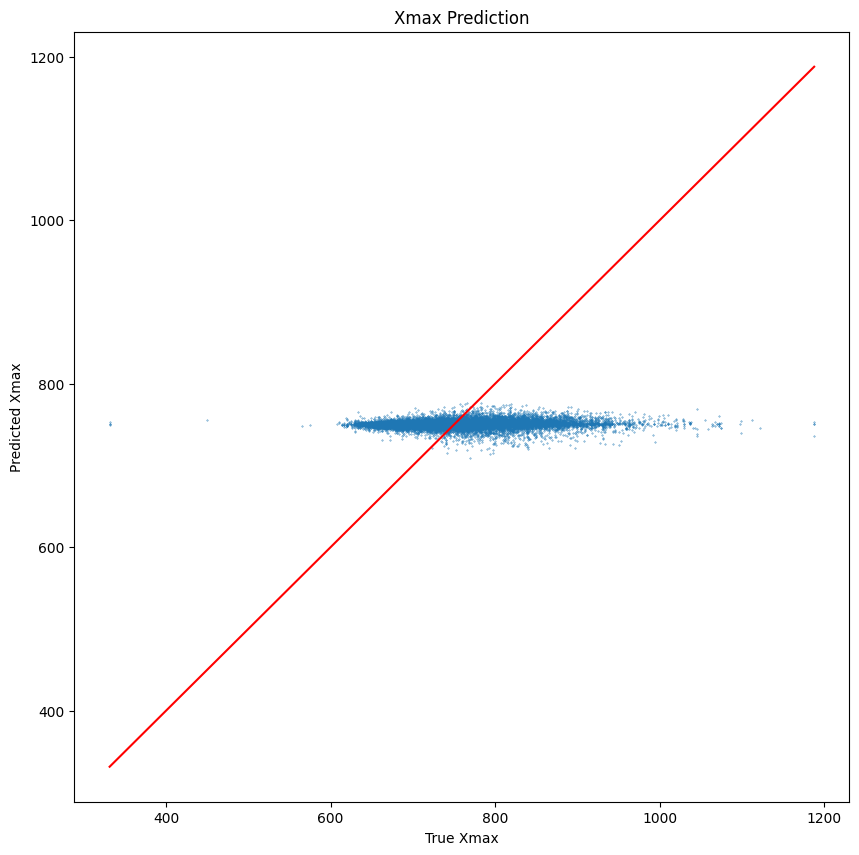

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(Xmax_test,Xmax_pred,s=0.1)
plt.plot([min(Xmax_test), max(Xmax_test)], [min(Xmax_test), max(Xmax_test)], color='red')  # ideal line
plt.xlabel('True Xmax')
plt.ylabel('Predicted Xmax')
plt.title('Xmax Prediction')
plt.show()

<Figure size 1000x1000 with 0 Axes>

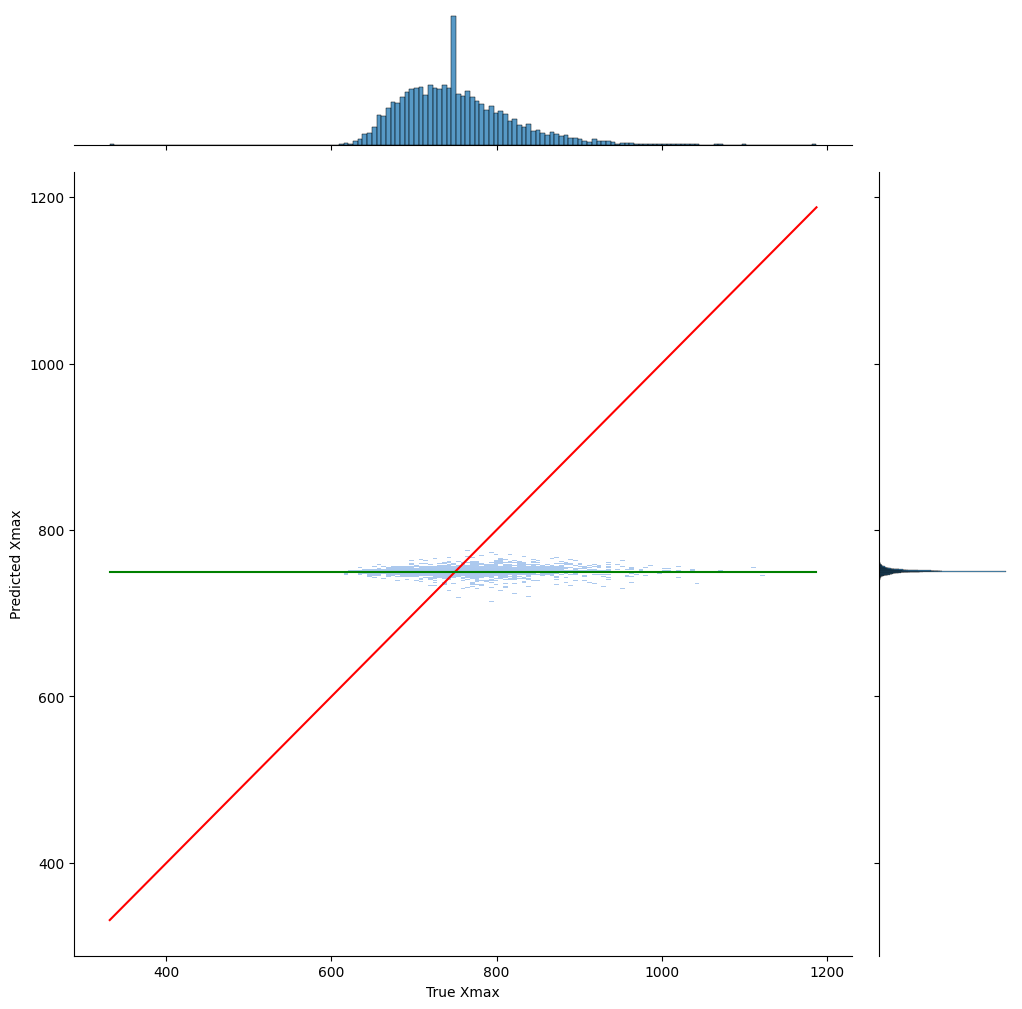

In [9]:
import seaborn as sns

# make a 2d histogram plot of Xmax and Predicted Xmax
plt.figure(figsize=(10,10))
fig = sns.jointplot(x=Xmax_test[:,0],y=Xmax_pred[:,0],kind = 'hist', height =10)
fig.ax_joint.plot([min(Xmax_test[:,0]), max(Xmax_test[:,0])], [min(Xmax_test[:,0]), max(Xmax_test[:,0])], color='red')  # ideal line
# plot line at Y=750 for the mean
fig.ax_joint.plot([min(Xmax_test[:,0]), max(Xmax_test[:,0])], [750, 750], color='green')  # ideal line
fig.set_axis_labels('True Xmax', 'Predicted Xmax')

# fig.ax_joint.set_ylim(740,760)
plt.savefig('/remote/tychodata/ftairli/work/Projects/TraceHexConv/Results/Xmax_Prediction.png')

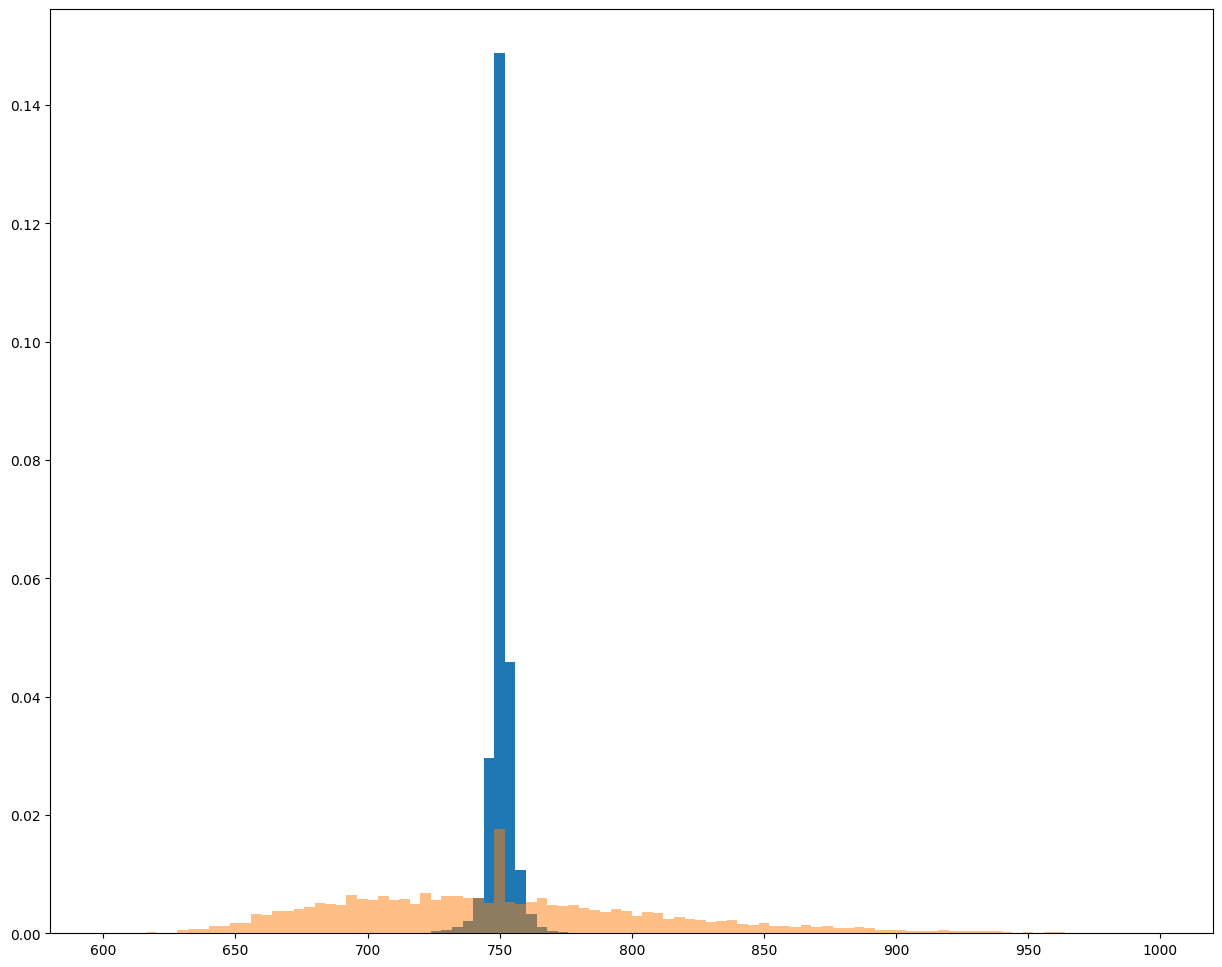

In [10]:
plt.hist(Xmax_pred,bins=100,density=True,range = [600,1000])
plt.hist(Xmax_test,bins=100,density=True,alpha=0.5,range = [600,1000])
# plt.savefig('../Results/Xmax_pred_distribution.png')
plt.show()

In [11]:
def angle_between_vectors(v1, v2):
    dot_product = np.sum(v1*v2, axis=1)
    magnitude_v1 = np.linalg.norm(v1, axis=1)
    magnitude_v2 = np.linalg.norm(v2, axis=1)
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    theta = np.arccos(np.clip(cos_theta, -1, 1)) # to avoid floating-point errors
    theta = np.degrees(theta)
    return theta

# # Substitute cause the above stopped working for some reason
# def angle_between_vectors(v1, v2):
#     dot_product = np.sum(v1*v2, axis=1)
#     theta = np.arccos(np.clip(dot_product,-1,1))
#     theta = np.degrees(theta)
#     return theta

In [12]:
E_res = np.abs(10**(logE_pred[:,0]-logE_test[:,0])-1)
C_res = np.linalg.norm(core_pred -Core_test,axis =1)
A_norm = np.sqrt(axis_pred[:,0]**2 + axis_pred[:,1]**2 + axis_pred[:,2]**2)
A_res = angle_between_vectors(axis_pred,Axis_test.detach().numpy())
X_res = np.sqrt((Xmax_test[:] - Xmax_pred[:])**2)


E_res = E_res[np.where(E_res<np.percentile(E_res,99))]
C_res = C_res[np.where(C_res<np.percentile(C_res,99))]
A_res = A_res[np.where(A_res<np.percentile(A_res,99))]
X_res = X_res[np.where(X_res<np.percentile(X_res,99))]

print(E_res.shape)
print(C_res.shape)
print(A_res.shape)
print(X_res.shape)

NameError: name 'logE_pred' is not defined

In [ ]:
Axis_test.shape

torch.Size([25000, 3])

Text(0.95, 0.95, '$\\sigma_{68} = 56.83^\\circ$')

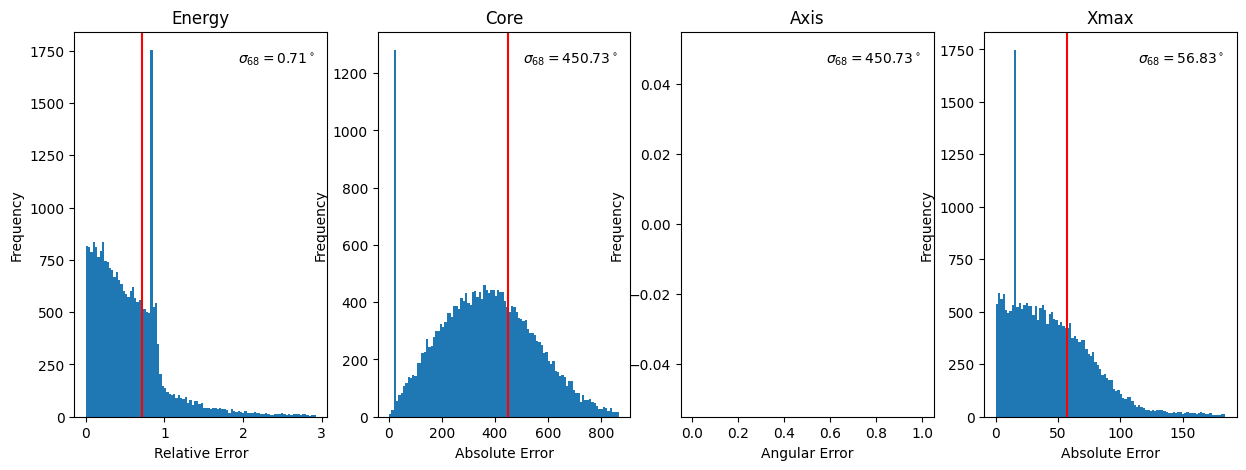

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(15,5))

reso = np.percentile(E_res,68)
ax[0].hist(E_res,bins=100)
ax[0].set_xlabel('Relative Error')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Energy')
# ax[0].set_yscale('log')
ax[0].axvline(reso,color='red',label='68%')
ax[0].text(0.95, 0.95, '$\sigma_{68} = %.2f^\circ$' % reso, ha='right', va='top', transform=ax[0].transAxes)


reso = np.percentile(C_res,68)
ax[1].hist(C_res,bins=100)
ax[1].set_xlabel('Absolute Error')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Core')
# ax[1].set_yscale('log')
ax[1].axvline(reso,color='red',label='68%')
ax[1].text(0.95, 0.95, '$\sigma_{68} = %.2f^\circ$' % reso, ha='right', va='top', transform=ax[1].transAxes)

# reso = np.percentile(A_res,68)
ax[2].hist(A_res,bins=100)
ax[2].set_xlabel('Angular Error')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Axis')
# ax[2].set_yscale('log')
# ax[2].axvline(np.percentile(A_res,68),color='red',label='68%')
ax[2].text(0.95, 0.95, '$\sigma_{68} = %.2f^\circ$' % reso, ha='right', va='top', transform=ax[2].transAxes)

reso = np.percentile(X_res,68)
ax[3].hist(X_res,bins=100)
ax[3].set_xlabel('Absolute Error')
ax[3].set_ylabel('Frequency')
ax[3].set_title('Xmax')
# ax[3].set_yscale('log')
ax[3].axvline(np.percentile(X_res,68),color='red',label='68%')
ax[3].text(0.95, 0.95, '$\sigma_{68} = %.2f^\circ$' % reso, ha='right', va='top', transform=ax[3].transAxes)


In [ ]:
print(D_main_test.shape)
print(D_aux_test.shape)
X_test = torch.cat([torch.sum(D_main_test.to_dense(),axis = (1,2)).unsqueeze(1),D_aux_test.unsqueeze(1),torch.ones(size=(25000,1,11,11))],axis = 1)
print(X_test.shape)

torch.Size([25000, 120, 3, 11, 11])
torch.Size([25000, 11, 11])
torch.Size([25000, 3, 11, 11])
